# SARIMAX

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns


from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
# Time split: train = first 4 years, test = 5th year
min_year = df.index.year.min()
train_mask = df.index.year < (min_year + 4)
val_mask = df.index.year == (min_year + 4)

y_train = df.loc[train_mask, 'NUMBER_INT']

# Remove last 5 days from validation
y_val = df.loc[val_mask, 'NUMBER_INT'][:-5]

y_train.count()

np.int64(1461)

### Granger

In [5]:
candidate_vars = ['IsWeekend', 'IsHoliday', 'IsDayAfterHoliday',
                  'temp_max', 'temp_min', 'humidity_min', 'humidity_max']

df_test = df[['NUMBER_INT'] + candidate_vars].dropna()

max_lag = 3

for var in candidate_vars:
    print(f"\nTesting Granger causality: {var} --> NUMBER_INT")
    result = grangercausalitytests(df_test[['NUMBER_INT', var]], maxlag=max_lag, verbose=False)
    for lag in range(1, max_lag + 1):
        p_value = result[lag][0]['ssr_chi2test'][1]
        print(f" Lag {lag}: p = {p_value:.4f} {'ok' if p_value < 0.05 else 'not ok'}")


Testing Granger causality: IsWeekend --> NUMBER_INT
 Lag 1: p = 0.0001 ok
 Lag 2: p = 0.0000 ok
 Lag 3: p = 0.0000 ok

Testing Granger causality: IsHoliday --> NUMBER_INT
 Lag 1: p = 0.3781 not ok
 Lag 2: p = 0.3738 not ok
 Lag 3: p = 0.2190 not ok

Testing Granger causality: IsDayAfterHoliday --> NUMBER_INT
 Lag 1: p = 0.1567 not ok
 Lag 2: p = 0.2861 not ok
 Lag 3: p = 0.2572 not ok

Testing Granger causality: temp_max --> NUMBER_INT
 Lag 1: p = 0.0000 ok
 Lag 2: p = 0.0000 ok
 Lag 3: p = 0.0000 ok

Testing Granger causality: temp_min --> NUMBER_INT
 Lag 1: p = 0.0000 ok
 Lag 2: p = 0.0000 ok
 Lag 3: p = 0.0000 ok

Testing Granger causality: humidity_min --> NUMBER_INT
 Lag 1: p = 0.5614 not ok
 Lag 2: p = 0.8147 not ok
 Lag 3: p = 0.8348 not ok

Testing Granger causality: humidity_max --> NUMBER_INT
 Lag 1: p = 0.0027 ok
 Lag 2: p = 0.0026 ok
 Lag 3: p = 0.0027 ok


c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since fu

In [6]:
exog_vars = ['temp_max', 'DayOfWeekNum', 'Month']

# Create exogenous data
X = df[exog_vars]
X_train = X.loc[y_train.index]
X_val = X.loc[y_val.index]

assert X_train.isnull().sum().sum() == 0, "Missing values in training exog"
assert X_val.isnull().sum().sum() == 0, "Missing values in validation exog"


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each exogenous variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print(vif_data)

       Variable       VIF
0      temp_max  6.424309
1  DayOfWeekNum  3.177133
2         Month  4.420005


In [8]:
sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2,1,1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results = sarimax_model.fit(disp=False)


c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Correia\Documents\Projects\hospital-adm-pw-rel\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
forecast_result = sarimax_results.get_forecast(steps=len(y_val), exog=X_val)
forecast_mean = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()

MAE:   11.08
RMSE:  13.63
MAPE:  22.02%
SMAPE: 21.87%
R^2:   0.2224
Corr:  0.51
                                     SARIMAX Results                                     
Dep. Variable:                        NUMBER_INT   No. Observations:                 1461
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -5194.115
Date:                           Thu, 02 Oct 2025   AIC                          10406.229
Time:                                   09:55:07   BIC                          10453.749
Sample:                               01-01-2015   HQIC                         10423.961
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp_max         0.1407      0.103    

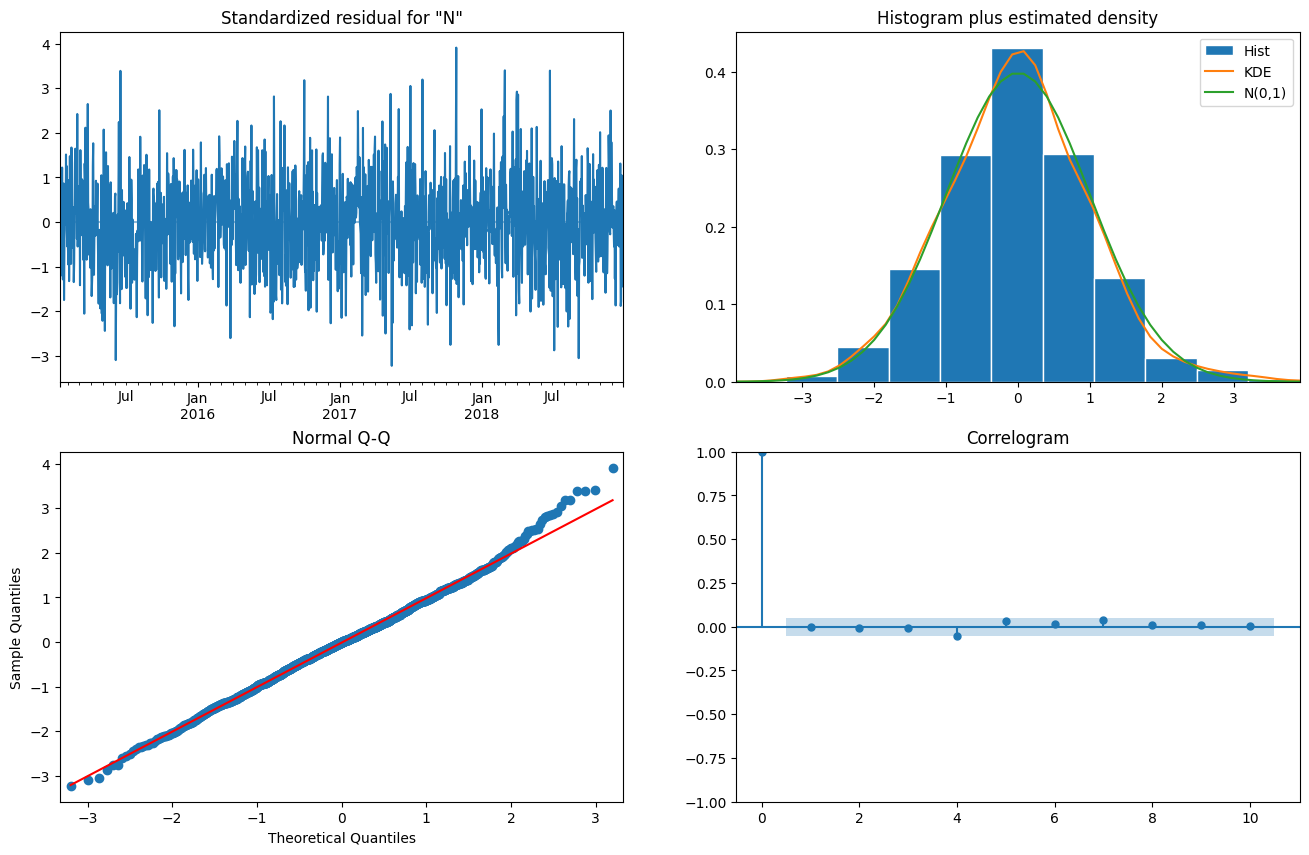

In [10]:
## Metrics

mse = mean_squared_error(y_val, forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, forecast_mean)
mape_val = mape(y_val, forecast_mean)
smape_val = smape(y_val, forecast_mean)
r2 = r2_score(y_val, forecast_mean)
corr = np.corrcoef(y_val, forecast_mean)[0, 1]

print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.4f}")
print(f"Corr:  {corr:.2f}")

print(sarimax_results.summary())
sarimax_results.plot_diagnostics(figsize=(16, 10))
plt.show()


In [11]:
## Metrics for First 30 Days

forecast_30 = forecast_mean[:30]

mse_30 = mean_squared_error(y_val[:30], forecast_30)
rmse_30 = np.sqrt(mse_30)
mae_30 = mean_absolute_error(y_val[:30], forecast_30)
mape_val_30 = mape(y_val[:30], forecast_30)
smape_val_30 = smape(y_val[:30], forecast_30)
r2_30 = r2_score(y_val[:30], forecast_30)
corr_30 = np.corrcoef(y_val[:30], forecast_30)[0, 1]

print(f"MAE:   {mae_30:.2f}")
print(f"RMSE:  {rmse_30:.2f}")
print(f"MAPE:  {mape_val_30:.2f}%")
print(f"SMAPE: {smape_val_30:.2f}%")
print(f"R^2:   {r2_30:.4f}")
print(f"Corr:  {corr_30:.2f}")


MAE:   8.34
RMSE:  10.15
MAPE:  23.29%
SMAPE: 19.65%
R^2:   -0.5399
Corr:  0.74


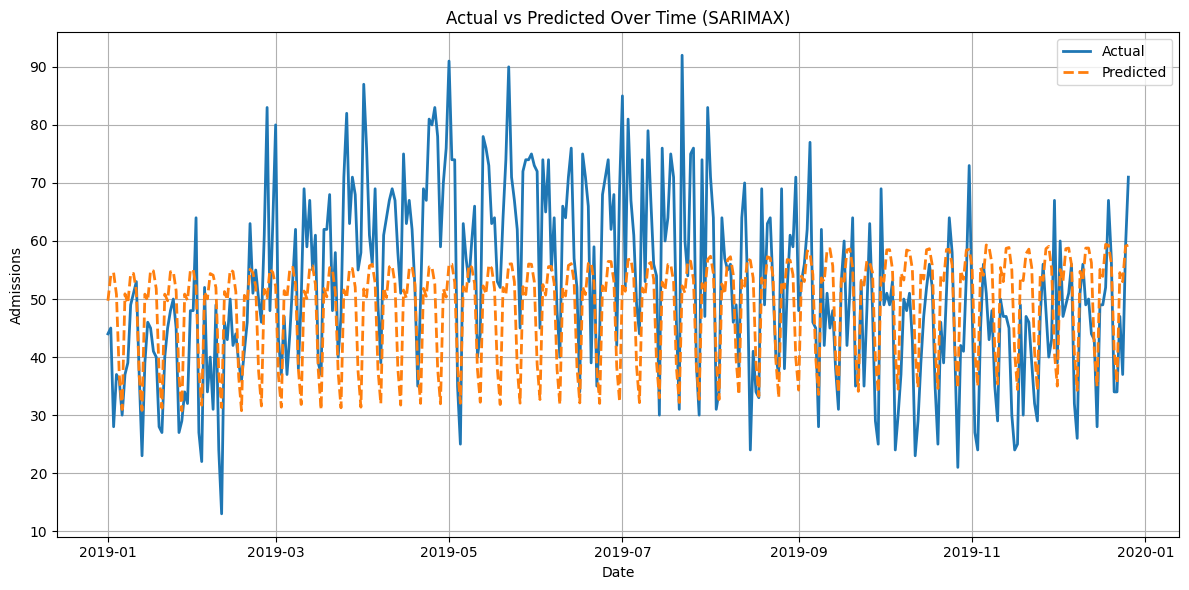

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(y_val.index, y_val, label='Actual', linewidth=2)

plt.plot(y_val.index, forecast_mean, label='Predicted', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Admissions')
plt.title('Actual vs Predicted Over Time (SARIMAX)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


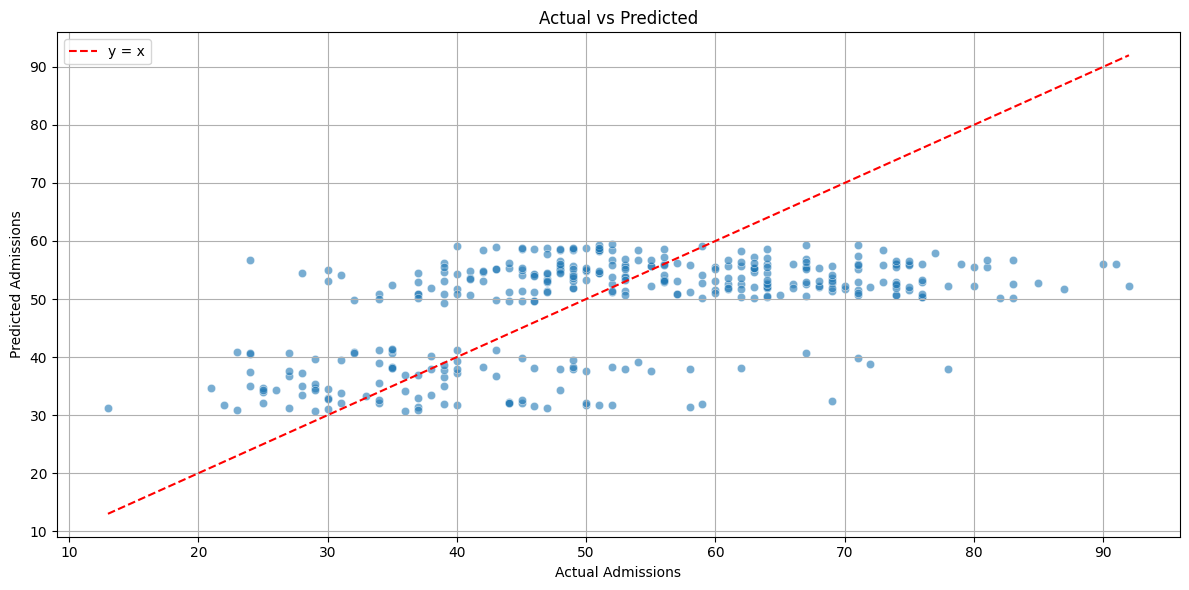

In [13]:
plt.figure(figsize=(12, 6))

sns.scatterplot(x=y_val, y=forecast_mean, alpha=0.6)

plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    color='red', linestyle='--', label='y = x'
)

plt.xlabel('Actual Admissions')
plt.ylabel('Predicted Admissions')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

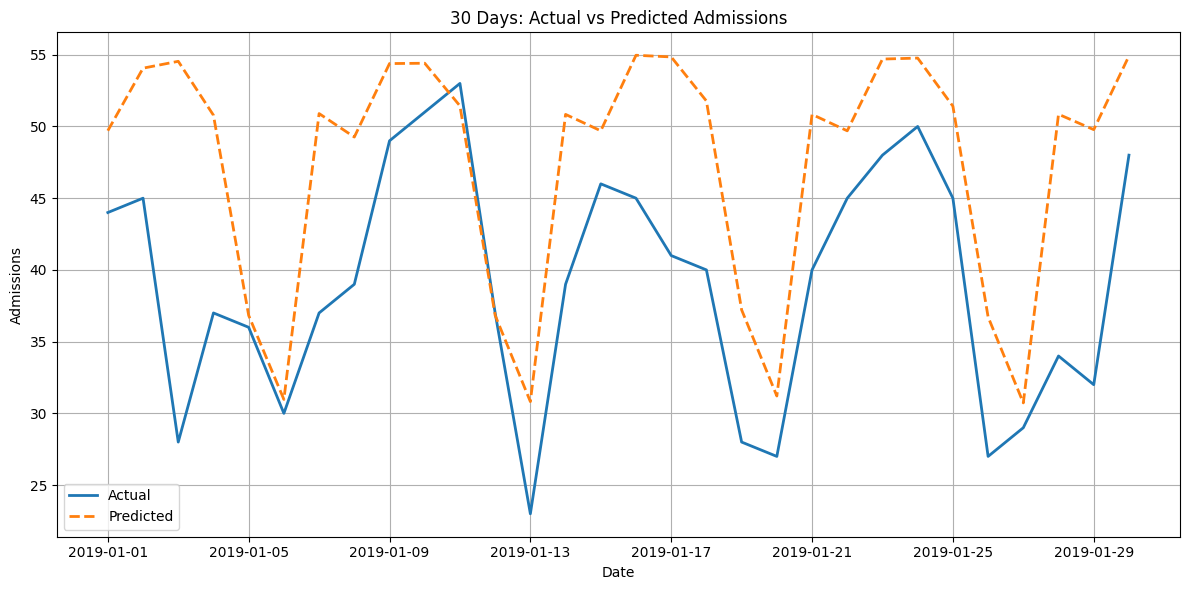

In [14]:
plt.figure(figsize=(12, 6))

plt.plot(y_val.index[:30], y_val[:30], label='Actual', linewidth=2)
plt.plot(y_val.index[:30], forecast_mean[:30], label='Predicted', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Admissions')
plt.title('30 Days: Actual vs Predicted Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


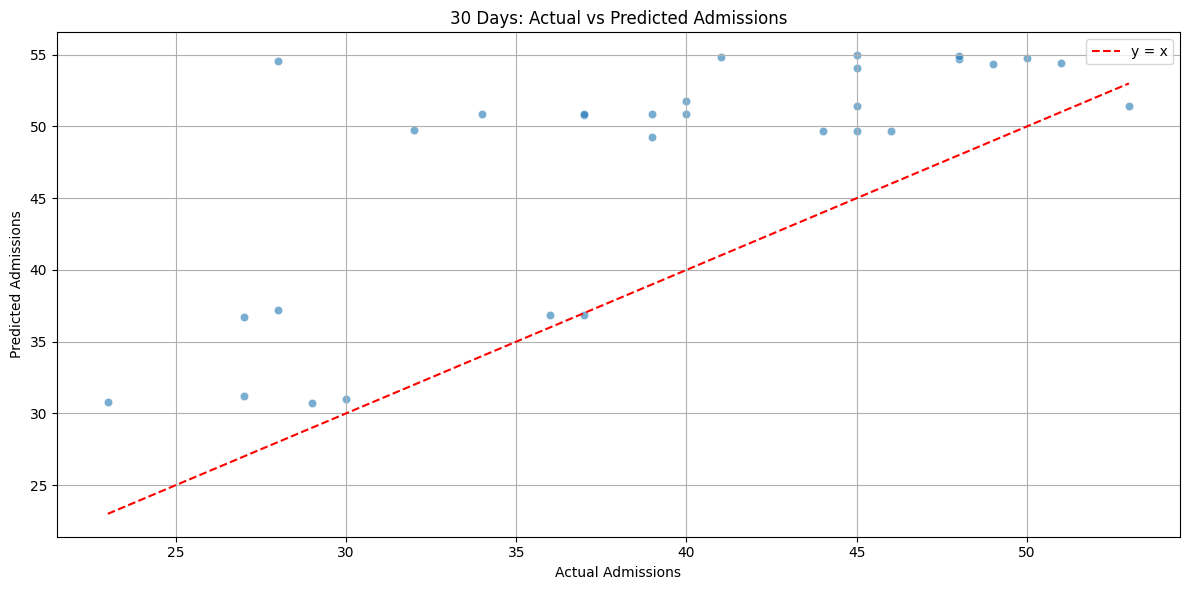

In [15]:
plt.figure(figsize=(12, 6))

sns.scatterplot(x=y_val[:30], y=forecast_mean[:30], alpha=0.6)

plt.plot(
    [y_val[:30].min(), y_val[:30].max()],
    [y_val[:30].min(), y_val[:30].max()],
    color='red', linestyle='--', label='y = x'
)

plt.xlabel('Actual Admissions')
plt.ylabel('Predicted Admissions')
plt.title('30 Days: Actual vs Predicted Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()